In [13]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [14]:
class Markowitz:
    def __init__(self, tickers:list, start: str, end: str) -> None:
        self.tickers = tickers
        self.start = start
        self.end = end
        self.log_returns = self._get_logarithmic_returns(tickers=self.tickers, start=self.start, end=self.end)
        self.n_assets = self.log_returns.shape[1]
        self.efficient_frontier = None
        self.simulated_PFs = None
    #     self.xlim = (1,2)
    #     self.ylim = (-0.25, 0.25)

    # def set_limits(self):
    #     plt.xlim(self.xlim)
    #     plt.ylim(self.ylim)
    
    def _get_logarithmic_returns(self, tickers: list, start: str, end: str)-> pd.DataFrame:
        data = yf.download(tickers=tickers, start=start, end=end)["Adj Close"]
        data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns)
        data = data.dropna(axis=0)
        return data
    
    def get_efficient_frontier(self):
        n_assets = self.n_assets
        log_returns = self.log_returns
        mu = np.mean(log_returns, axis=0).to_numpy()
        cov = np.cov(log_returns, rowvar=False)
        C1 = np.linalg.inv(cov)
        a = np.matmul(np.matmul(mu, C1), mu)
        b = np.matmul(np.ones((1, n_assets)) ,np.matmul(C1, mu))[0]
        d = np.matmul(np.ones((1, n_assets)), np.matmul(C1, np.ones((n_assets,1))))[0][0]
        wvarmin = (1/d) * np.matmul(C1, np.ones((6,1)))
        sigmamin = 1/np.sqrt(d)
        mumin = b/d
        sigma_p = np.arange(sigmamin, 5, 0.001)
        upper_optimal_PF = np.empty(shape=(sigma_p.shape[0],2))
        upper_optimal_PF[:,0] = sigma_p
        for i in range(0,upper_optimal_PF.shape[0]):
            upper_optimal_PF[i,1] = mumin + np.sqrt((np.square(upper_optimal_PF[i,0]) - np.square(sigmamin)) * (a - np.square(mumin)/np.square(sigmamin)))
        lower_optimal_PF = np.empty(shape=(sigma_p.shape[0],2))
        lower_optimal_PF[:,0] = sigma_p
        for i in range(0,lower_optimal_PF.shape[0]):
            lower_optimal_PF[i,1] = mumin - np.sqrt((np.square(lower_optimal_PF[i,0]) - np.square(sigmamin)) * (a - np.square(mumin)/np.square(sigmamin)))
        efficient_frontier = np.concatenate((upper_optimal_PF, lower_optimal_PF))
        efficient_frontier = pd.DataFrame(efficient_frontier, columns=['std', 'mu'])
        self.efficient_frontier = efficient_frontier

    def plot_efficient_frontier(self):
        if self.efficient_frontier is None:
            print('No efficient frontier computed')
        else:
            sns.scatterplot(x = self.efficient_frontier['std'], y = self.efficient_frontier['mu'], edgecolor=None, s=1)

    def get_minimum_variance_portfolio(self):
        pass

    def simulate_portfolios(self, n_portfolios=500, allow_negative_weights=True):
        
        random_portfolio_weights = self._get_random_portfolio_weights(n_portfolios=n_portfolios, allow_negative_weights=allow_negative_weights)
        simulated_PFs = np.empty(shape=(n_portfolios, 2))
        for i in range(0, n_portfolios):
            temp_return = (random_portfolio_weights[i] * self.log_returns).sum(axis=1)
            simulated_PFs[i,0] = temp_return.mean()
            simulated_PFs[i,1] = temp_return.std()
        self.simulated_PFs =  pd.DataFrame(simulated_PFs, columns=['mu', 'std'])
    
    def _get_random_portfolio_weights(self, n_portfolios, allow_negative_weights=True):
        if allow_negative_weights:
            random_portfolio_weights = np.random.uniform(-1, 1, size=(n_portfolios,self.n_assets))
        else:
            random_portfolio_weights = np.random.uniform(0, 1, size=(n_portfolios,self.n_assets))
        random_portfolio_weights = random_portfolio_weights/random_portfolio_weights.sum(axis=1, keepdims=True)
        return random_portfolio_weights
    
    def plot_random_PFs(self):
        if self.simulated_PFs is None:
            print('Simulate random PFs first')
        else:
            sns.scatterplot(x = self.simulated_PFs['std'], y = self.simulated_PFs['mu'], edgecolor=None, s=1)

    def plot(self):
        """
        Plots the efficient frontier of the portfolio and simulated portfolio returns, if portfolios were simulated beforehand.
        """
        if self.efficient_frontier is None:
            print('No efficient frontier computed. Efficient frontier will be computed')
            self.get_efficient_frontier()
        plt.xlim([1, 2])
        plt.ylim([-.25, .25])
        sns.scatterplot(x = self.efficient_frontier['std'], y = self.efficient_frontier['mu'], edgecolor=None, s=1)
        
        if self.simulated_PFs is None:
            pass
        else:
            plt.xlim([1, 2])
            plt.ylim([-.25, .25])
            sns.scatterplot(x = self.simulated_PFs['std'], y = self.simulated_PFs['mu'], edgecolor=None, s=1)


In [15]:
PF = Markowitz(tickers=["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%%**********************]  6 of 6 completed


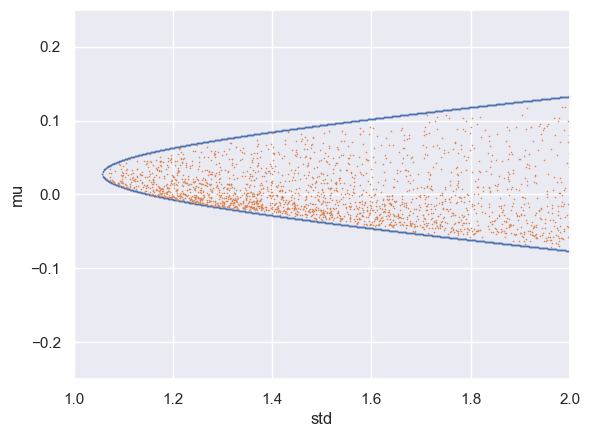

In [18]:
PF.plot()

In [17]:
PF.simulate_portfolios(n_portfolios=5000, allow_negative_weights=True)